# Logistic Regression for Product Title Classification
## Comparative Analysis with Multiple Word Embeddings

**Author:** David CYUBAHIRO 
**Date:** February 7, 2026  
**Model:** Logistic Regression  
**Embeddings:** TF-IDF, Word2Vec (Skip-gram), Word2Vec (CBOW), FastText

---

### Objective
This notebook implements and evaluates Logistic Regression classifiers using four different word embedding techniques. The goal is to compare performance across embeddings.

## 1. Import Required Libraries

## 0. Install Required Packages

Run this cell first if you don't have the required libraries installed.

In [ ]:
# Install required packages
!pip install pandas numpy scikit-learn gensim matplotlib seaborn

In [2]:
# Standard libraries
import os
import json
import pickle
import warnings
from datetime import datetime

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
)

# Word Embeddings
import gensim
from gensim.models import Word2Vec, FastText

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Gensim version: {gensim.__version__}")

All libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 2.2.5
Gensim version: 4.4.0


## 2. Configuration and Setup

In [3]:
# Directory paths
RESULTS_BASE = "../results"
EDA_DIR = os.path.join(RESULTS_BASE, "EDA")
OUTPUT_DIR = os.path.join(RESULTS_BASE, "LogisticRegression")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")
GRAPHS_DIR = os.path.join(OUTPUT_DIR, "visual_graphs")

# Data file paths (try multiple locations)
TRAIN_CSV_PATHS = [
    os.path.join(RESULTS_BASE, "train.csv"),
    os.path.join(EDA_DIR, "train.csv"),
]
TEST_CSV_PATHS = [
    os.path.join(RESULTS_BASE, "test.csv"),
    os.path.join(EDA_DIR, "test.csv"),
]

# Column names
TEXT_COL = "clean_text"
LABEL_COL = "label_id"
CATEGORY_COL = "category_name"

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Model parameters
EMBEDDING_DIM = 100
MIN_WORD_COUNT = 2
WINDOW_SIZE = 5
WORKERS = 4

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(GRAPHS_DIR, exist_ok=True)

print("Configuration completed!")
print(f"Output directory: {OUTPUT_DIR}")

Configuration completed!
Output directory: ../results\LogisticRegression


## 3. Load Data

### Option: Download Dataset and Run Preprocessing

**If you don't have the data files yet:**

1. **Download from Kaggle**: https://www.kaggle.com/datasets/asaniczka/product-titles-text-classification
   - Download `titles_to_categories.csv`
   - Place it in `../data/titles_to_categories.csv`

2. **Run preprocessing**:
   ```python
   # Uncomment and run if you need to generate train/test splits
   # !cd ../src && python preprocessing.py
   ```

3. **OR ask your teammate** for `train.csv` and `test.csv` files and place them in `../results/`

After getting the files, restart from the cell below.

In [4]:
# Quick check: Do you have the data files?
import os

data_files_exist = (
    os.path.exists("../results/train.csv") and 
    os.path.exists("../results/test.csv")
)

if data_files_exist:
    print("✓ Data files found! You can proceed with the experiments.")
else:
    print("✗ Data files NOT found.")
    print("\nYou need to either:")
    print("1. Ask your teammate for train.csv and test.csv")
    print("2. Download raw data from Kaggle and run preprocessing")
    print("\nSee instructions in the cell above ↑")

✓ Data files found! You can proceed with the experiments.


In [5]:
# OPTION: Run preprocessing if you have the raw data
# Uncomment the lines below if you've downloaded titles_to_categories.csv to ../data/

# import subprocess
# import sys
# 
# print("Running preprocessing script...")
# result = subprocess.run(
#     [sys.executable, "../src/preprocessing.py"],
#     capture_output=True,
#     text=True
# )
# 
# if result.returncode == 0:
#     print("✓ Preprocessing completed successfully!")
#     print(result.stdout)
# else:
#     print("✗ Preprocessing failed:")
#     print(result.stderr)

In [6]:
def find_data_file(paths):
    """Find the first existing file from a list of paths."""
    for path in paths:
        if os.path.exists(path):
            return path
    return None

# Load training data
train_path = find_data_file(TRAIN_CSV_PATHS)
test_path = find_data_file(TEST_CSV_PATHS)

if train_path is None or test_path is None:
    print("="*70)
    print("⚠️  DATA FILES NOT FOUND")
    print("="*70)
    print("\nThe preprocessed data files (train.csv, test.csv) are missing.")
    print("\n📋 QUICK FIX - Choose ONE option:\n")
    
    print("✅ Option 1 (FASTEST - Recommended):")
    print("   Ask your teammate who ran the GRU experiments for:")
    print("   • train.csv")
    print("   • test.csv")
    print("   Place them in: C:\\Users\\cyuba\\Documents\\LEARN\\ALU\\Product\\Product-text-Classiifcation\\results\\")
    print()
    
    print(" Option 2 (If you have the raw dataset):")
    print("   1. Download from Kaggle: https://www.kaggle.com/datasets/asaniczka/product-titles-text-classification")
    print("   2. Place titles_to_categories.csv in ../data/")
    print("   3. Uncomment and run cell 10 above to generate train/test splits")
    print()
    
    print("After getting the files, restart the kernel and run all cells.")
    print("="*70)
    
    # Set flags so later cells can check
    DATA_FILES_AVAILABLE = False
    train_df = None
    test_df = None
else:
    print(f"✓ Found training data: {train_path}")
    train_df = pd.read_csv(train_path)
    
    print(f"✓ Found test data: {test_path}")
    test_df = pd.read_csv(test_path)
    
    print(f"\n{'='*70}")
    print("✅ DATA LOADED SUCCESSFULLY")
    print("="*70)
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    print(f"Columns: {train_df.columns.tolist()}")
    print(f"Number of classes: {train_df[LABEL_COL].nunique()}")
    
    DATA_FILES_AVAILABLE = True
    
    # Display sample
    print("\nSample data:")
    display(train_df.head())

✓ Found training data: ../results\train.csv
✓ Found test data: ../results\test.csv

✅ DATA LOADED SUCCESSFULLY
Train shape: (399997, 3)
Test shape: (100000, 3)
Columns: ['clean_text', 'label_id', 'category_name']
Number of classes: 63

Sample data:


,clean_text,label_id,category_name
0,43inch tv led backlight strip bn96 37294a 3729...,58,Televisions
1,tweezerman mini slant tweezer green tea,52,Shaving Hair Removal Products
2,electric nose hair trimmer ear and nose hair t...,52,Shaving Hair Removal Products
3,women s high top sneaker comfortable casual la...,62,Women's Shoes
4,mtssii cat eye gel nail polish moonstone cat e...,7,Beauty


## 4. Data Preparation

In [7]:
# Check if data is available before proceeding
if train_df is None or test_df is None:
    print("⚠️  Cannot proceed - data files are missing!")
    print("Please follow the instructions in the previous cells to get the data.")
    print("After getting train.csv and test.csv, restart the kernel and run all cells.")
else:
    # Extract features and labels
    X_train_text = train_df[TEXT_COL].values
    X_test_text = test_df[TEXT_COL].values
    y_train = train_df[LABEL_COL].values
    y_test = test_df[LABEL_COL].values
    
    print(f"✓ Data preparation complete!")
    print(f"Training samples: {len(X_train_text):,}")
    print(f"Test samples: {len(X_test_text):,}")
    print(f"Label range: {y_train.min()} to {y_train.max()}")
    
    # Class distribution
    class_dist = train_df[LABEL_COL].value_counts().sort_index()
    print(f"\nClass distribution (first 10):")
    print(class_dist.head(10))

✓ Data preparation complete!
Training samples: 399,997
Test samples: 100,000
Label range: 0 to 62

Class distribution (first 10):
label_id
0     7536
1     3747
2     7561
3       27
4     4242
5    13745
6     6914
7    14946
8    13055
9       13
Name: count, dtype: int64


## 5. Helper Functions

In [8]:
def tokenize_text(text):
    """Simple tokenization by splitting on whitespace."""
    return str(text).split()

def save_classification_report(y_true, y_pred, embedding_name):
    """Save detailed classification report to file."""
    report = classification_report(y_true, y_pred, zero_division=0)
    
    report_path = os.path.join(OUTPUT_DIR, f"classification_report_{embedding_name}.txt")
    with open(report_path, 'w') as f:
        f.write(report)
    
    print(f"Saved classification report to: {report_path}")
    return report

def save_model_and_embedder(model, embedder, embedding_name):
    """Save trained model and embedding object."""
    model_path = os.path.join(MODELS_DIR, f"logreg_{embedding_name}.pkl")
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    embedder_path = os.path.join(MODELS_DIR, f"embedder_{embedding_name}.pkl")
    with open(embedder_path, 'wb') as f:
        pickle.dump(embedder, f)
    
    print(f"Saved model to: {model_path}")
    print(f"Saved embedder to: {embedder_path}")

def plot_confusion_matrix(y_true, y_pred, embedding_name, top_n=20):
    """Plot confusion matrix for top N classes."""
    # Get top N most frequent classes
    top_classes = pd.Series(y_true).value_counts().head(top_n).index.tolist()
    
    # Filter predictions for top classes
    mask = np.isin(y_true, top_classes)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=top_classes, yticklabels=top_classes)
    plt.title(f'Confusion Matrix - Logistic Regression ({embedding_name})\nTop {top_n} Classes')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    save_path = os.path.join(GRAPHS_DIR, f'confusion_matrix_{embedding_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {save_path}")
    plt.show()

print("Helper functions defined!")

Helper functions defined!


## 6. Experiment 1: TF-IDF + Logistic Regression

### 6.1 Create TF-IDF Features

In [9]:
# Check if data is available
if 'X_train_text' not in globals() or X_train_text is None:
    print("⚠️  ERROR: Training data not available!")
    print("Please run the data loading cells above first.")
    print("Make sure train.csv and test.csv are in ../results/")
else:
    print("="*70)
    print("EXPERIMENT 1: TF-IDF + Logistic Regression")
    print("="*70)
    
    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),  # unigrams and bigrams
        min_df=2,
        sublinear_tf=True,
    )
    
    # Transform texts
    print("\nCreating TF-IDF features...")
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
    X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
    
    print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
    print(f"Train shape: {X_train_tfidf.shape}")
    print(f"Test shape: {X_test_tfidf.shape}")
    print(f"Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

EXPERIMENT 1: TF-IDF + Logistic Regression

Creating TF-IDF features...
TF-IDF vocabulary size: 10000
Train shape: (399997, 10000)
Test shape: (100000, 10000)
Sparsity: 99.82%


### 6.2 Hyperparameter Tuning with GridSearchCV

In [10]:
# Check if TF-IDF features are available
if 'X_train_tfidf' not in globals() or X_train_tfidf is None:
    print("⚠️  ERROR: TF-IDF features not available!")
    print("Please run the TF-IDF feature creation cell above first.")
    print("Make sure the data files are loaded successfully.")
else:
    # Define parameter grid
    param_grid_tfidf = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [500],
        'class_weight': ['balanced'],
    }
    
    print("Hyperparameter tuning for TF-IDF...")
    print(f"Parameter grid: {param_grid_tfidf}")
    
    # GridSearchCV
    lr_tfidf_grid = GridSearchCV(
        LogisticRegression(random_state=RANDOM_SEED),
        param_grid_tfidf,
        cv=3,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=2,
    )
    
    lr_tfidf_grid.fit(X_train_tfidf, y_train)
    
    print(f"\nBest parameters: {lr_tfidf_grid.best_params_}")
    print(f"Best CV F1-macro: {lr_tfidf_grid.best_score_:.4f}")
    
    # Get best model
    lr_tfidf = lr_tfidf_grid.best_estimator_

Hyperparameter tuning for TF-IDF...
Parameter grid: {'C': [0.01, 0.1, 1.0, 10.0], 'penalty': ['l2'], 'solver': ['lbfgs'], 'max_iter': [500], 'class_weight': ['balanced']}
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 10.0, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-macro: 0.8273


### 6.3 Evaluation


TF-IDF Results:
Test Accuracy:    0.8665
Macro F1:         0.8358
Weighted F1:      0.8662
Saved classification report to: ../results\LogisticRegression\classification_report_tfidf.txt
Saved model to: ../results\LogisticRegression\models\logreg_tfidf.pkl
Saved embedder to: ../results\LogisticRegression\models\embedder_tfidf.pkl
Saved confusion matrix to: ../results\LogisticRegression\visual_graphs\confusion_matrix_tfidf.png


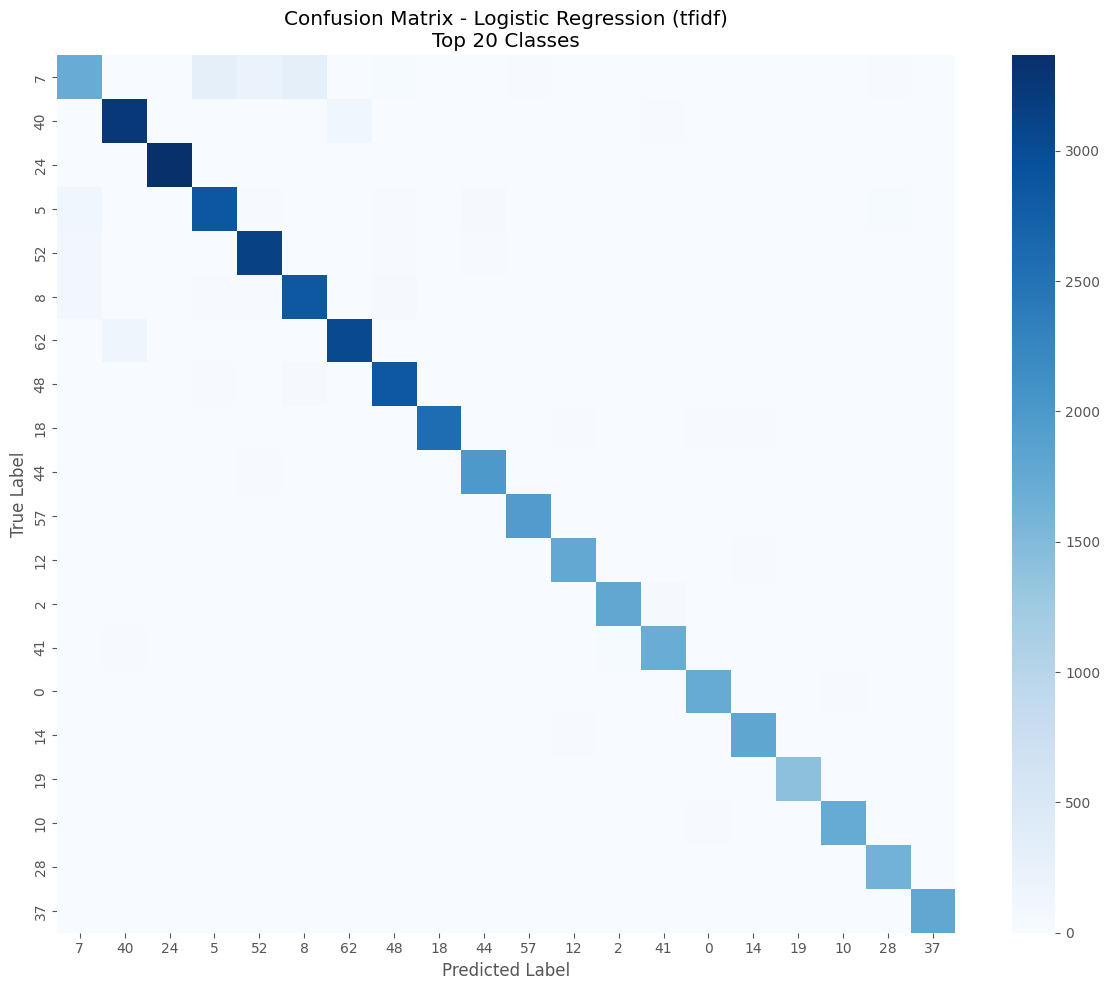

In [11]:
# Check if model was trained
if 'lr_tfidf' not in globals() or lr_tfidf is None:
    print("⚠️  ERROR: TF-IDF model not trained!")
    print("Please run the hyperparameter tuning cell above first.")
    print("Make sure all previous cells executed successfully.")
else:
    # Predictions
    y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
    
    # Metrics
    tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)
    tfidf_macro_f1 = f1_score(y_test, y_pred_tfidf, average='macro')
    tfidf_weighted_f1 = f1_score(y_test, y_pred_tfidf, average='weighted')
    
    print("\n" + "="*70)
    print("TF-IDF Results:")
    print("="*70)
    print(f"Test Accuracy:    {tfidf_accuracy:.4f}")
    print(f"Macro F1:         {tfidf_macro_f1:.4f}")
    print(f"Weighted F1:      {tfidf_weighted_f1:.4f}")
    
    # Save detailed report
    tfidf_report = save_classification_report(y_test, y_pred_tfidf, "tfidf")
    
    # Save model
    save_model_and_embedder(lr_tfidf, tfidf_vectorizer, "tfidf")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred_tfidf, "tfidf")

## 7. Experiment 2: Word2Vec Skip-gram + Logistic Regression

### 7.1 Train Word2Vec Skip-gram Model

In [12]:
print("\n" + "="*70)
print("EXPERIMENT 2: Word2Vec Skip-gram + Logistic Regression")
print("="*70)

# Tokenize texts
print("\nTokenizing texts...")
train_sentences = [tokenize_text(text) for text in X_train_text]

# Train Word2Vec Skip-gram
print("Training Word2Vec Skip-gram model...")
w2v_skipgram = Word2Vec(
    sentences=train_sentences,
    vector_size=EMBEDDING_DIM,
    window=WINDOW_SIZE,
    min_count=MIN_WORD_COUNT,
    sg=1,  # Skip-gram
    workers=WORKERS,
    seed=RANDOM_SEED,
    epochs=10,
)

print(f"Vocabulary size: {len(w2v_skipgram.wv)}")


EXPERIMENT 2: Word2Vec Skip-gram + Logistic Regression

Tokenizing texts...
Training Word2Vec Skip-gram model...
Vocabulary size: 81700


### 7.2 Convert Texts to Vectors

In [13]:
def text_to_word2vec_vector(text, w2v_model):
    """Convert text to averaged Word2Vec vector."""
    tokens = tokenize_text(text)
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(EMBEDDING_DIM)

print("Converting texts to Skip-gram vectors...")
X_train_skipgram = np.array([text_to_word2vec_vector(text, w2v_skipgram) for text in X_train_text])
X_test_skipgram = np.array([text_to_word2vec_vector(text, w2v_skipgram) for text in X_test_text])

print(f"Train shape: {X_train_skipgram.shape}")
print(f"Test shape: {X_test_skipgram.shape}")

Converting texts to Skip-gram vectors...
Train shape: (399997, 100)
Test shape: (100000, 100)


### 7.3 Train and Evaluate

Hyperparameter tuning for Skip-gram...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 10.0, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-macro: 0.7644

Skip-gram Results:
Test Accuracy:    0.8211
Macro F1:         0.7659
Weighted F1:      0.8220
Saved classification report to: ../results\LogisticRegression\classification_report_skipgram.txt
Saved model to: ../results\LogisticRegression\models\logreg_skipgram.pkl
Saved embedder to: ../results\LogisticRegression\models\embedder_skipgram.pkl
Saved confusion matrix to: ../results\LogisticRegression\visual_graphs\confusion_matrix_skipgram.png


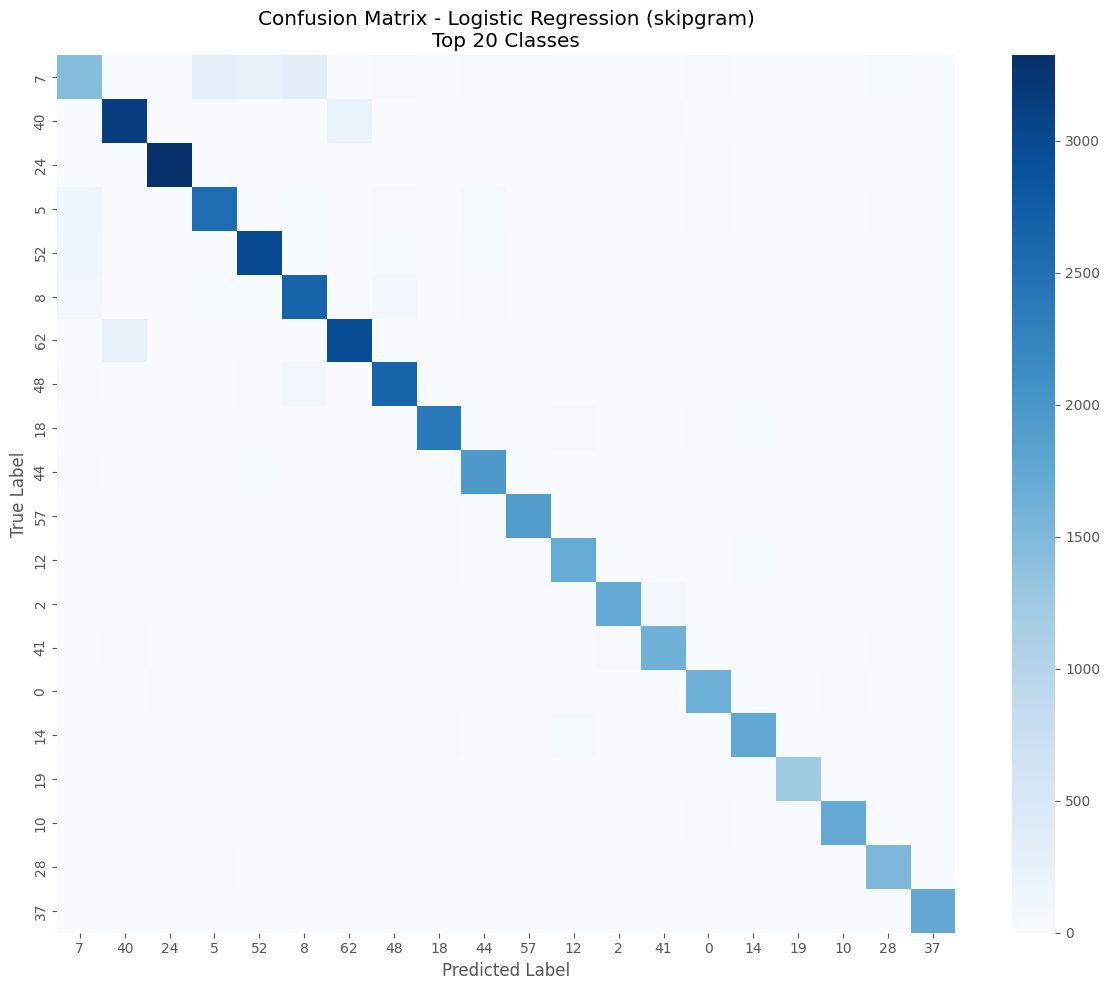

In [14]:
# Hyperparameter tuning
param_grid_w2v = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [500],
    'class_weight': ['balanced'],
}

print("Hyperparameter tuning for Skip-gram...")
lr_skipgram_grid = GridSearchCV(
    LogisticRegression(random_state=RANDOM_SEED),
    param_grid_w2v,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
)

lr_skipgram_grid.fit(X_train_skipgram, y_train)

print(f"\nBest parameters: {lr_skipgram_grid.best_params_}")
print(f"Best CV F1-macro: {lr_skipgram_grid.best_score_:.4f}")

lr_skipgram = lr_skipgram_grid.best_estimator_

# Evaluate
y_pred_skipgram = lr_skipgram.predict(X_test_skipgram)

skipgram_accuracy = accuracy_score(y_test, y_pred_skipgram)
skipgram_macro_f1 = f1_score(y_test, y_pred_skipgram, average='macro')
skipgram_weighted_f1 = f1_score(y_test, y_pred_skipgram, average='weighted')

print("\n" + "="*70)
print("Skip-gram Results:")
print("="*70)
print(f"Test Accuracy:    {skipgram_accuracy:.4f}")
print(f"Macro F1:         {skipgram_macro_f1:.4f}")
print(f"Weighted F1:      {skipgram_weighted_f1:.4f}")

# Save
save_classification_report(y_test, y_pred_skipgram, "skipgram")
save_model_and_embedder(lr_skipgram, w2v_skipgram, "skipgram")
plot_confusion_matrix(y_test, y_pred_skipgram, "skipgram")

## 8. Experiment 3: Word2Vec CBOW + Logistic Regression

### 8.1 Train Word2Vec CBOW Model

In [15]:
print("\n" + "="*70)
print("EXPERIMENT 3: Word2Vec CBOW + Logistic Regression")
print("="*70)

# Train Word2Vec CBOW
print("Training Word2Vec CBOW model...")
w2v_cbow = Word2Vec(
    sentences=train_sentences,
    vector_size=EMBEDDING_DIM,
    window=WINDOW_SIZE,
    min_count=MIN_WORD_COUNT,
    sg=0,  # CBOW
    workers=WORKERS,
    seed=RANDOM_SEED,
    epochs=10,
)

print(f"Vocabulary size: {len(w2v_cbow.wv)}")


EXPERIMENT 3: Word2Vec CBOW + Logistic Regression
Training Word2Vec CBOW model...
Vocabulary size: 81700


### 8.2 Convert Texts and Train

Converting texts to CBOW vectors...
Train shape: (399997, 100)
Test shape: (100000, 100)

Hyperparameter tuning for CBOW...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-macro: 0.7453

CBOW Results:
Test Accuracy:    0.8090
Macro F1:         0.7472
Weighted F1:      0.8104
Saved classification report to: ../results\LogisticRegression\classification_report_cbow.txt
Saved model to: ../results\LogisticRegression\models\logreg_cbow.pkl
Saved embedder to: ../results\LogisticRegression\models\embedder_cbow.pkl
Saved confusion matrix to: ../results\LogisticRegression\visual_graphs\confusion_matrix_cbow.png


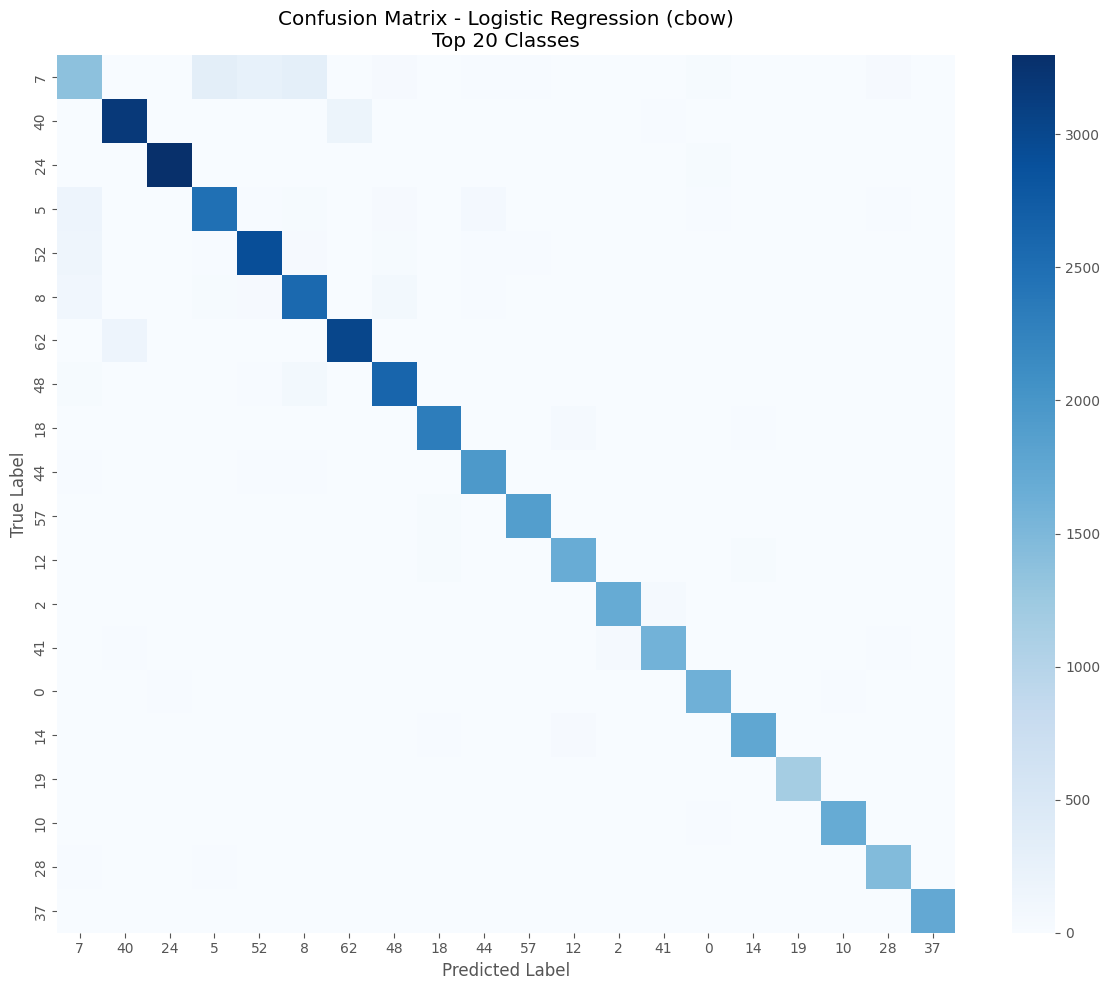

In [16]:
print("Converting texts to CBOW vectors...")
X_train_cbow = np.array([text_to_word2vec_vector(text, w2v_cbow) for text in X_train_text])
X_test_cbow = np.array([text_to_word2vec_vector(text, w2v_cbow) for text in X_test_text])

print(f"Train shape: {X_train_cbow.shape}")
print(f"Test shape: {X_test_cbow.shape}")

# Hyperparameter tuning
print("\nHyperparameter tuning for CBOW...")
lr_cbow_grid = GridSearchCV(
    LogisticRegression(random_state=RANDOM_SEED),
    param_grid_w2v,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
)

lr_cbow_grid.fit(X_train_cbow, y_train)

print(f"\nBest parameters: {lr_cbow_grid.best_params_}")
print(f"Best CV F1-macro: {lr_cbow_grid.best_score_:.4f}")

lr_cbow = lr_cbow_grid.best_estimator_

# Evaluate
y_pred_cbow = lr_cbow.predict(X_test_cbow)

cbow_accuracy = accuracy_score(y_test, y_pred_cbow)
cbow_macro_f1 = f1_score(y_test, y_pred_cbow, average='macro')
cbow_weighted_f1 = f1_score(y_test, y_pred_cbow, average='weighted')

print("\n" + "="*70)
print("CBOW Results:")
print("="*70)
print(f"Test Accuracy:    {cbow_accuracy:.4f}")
print(f"Macro F1:         {cbow_macro_f1:.4f}")
print(f"Weighted F1:      {cbow_weighted_f1:.4f}")

# Save
save_classification_report(y_test, y_pred_cbow, "cbow")
save_model_and_embedder(lr_cbow, w2v_cbow, "cbow")
plot_confusion_matrix(y_test, y_pred_cbow, "cbow")

## 9. Experiment 4: FastText + Logistic Regression

### 9.1 Train FastText Model

In [17]:
print("\n" + "="*70)
print("EXPERIMENT 4: FastText + Logistic Regression")
print("="*70)

# Train FastText
print("Training FastText model...")
fasttext_model = FastText(
    sentences=train_sentences,
    vector_size=EMBEDDING_DIM,
    window=WINDOW_SIZE,
    min_count=MIN_WORD_COUNT,
    workers=WORKERS,
    seed=RANDOM_SEED,
    epochs=10,
)

print(f"Vocabulary size: {len(fasttext_model.wv)}")


EXPERIMENT 4: FastText + Logistic Regression
Training FastText model...
Vocabulary size: 81700


### 9.2 Convert Texts and Train

Converting texts to FastText vectors...
Train shape: (399997, 100)
Test shape: (100000, 100)

Hyperparameter tuning for FastText...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-macro: 0.7321

FastText Results:
Test Accuracy:    0.7969
Macro F1:         0.7336
Weighted F1:      0.7987
Saved classification report to: ../results\LogisticRegression\classification_report_fasttext.txt
Saved model to: ../results\LogisticRegression\models\logreg_fasttext.pkl
Saved embedder to: ../results\LogisticRegression\models\embedder_fasttext.pkl
Saved confusion matrix to: ../results\LogisticRegression\visual_graphs\confusion_matrix_fasttext.png


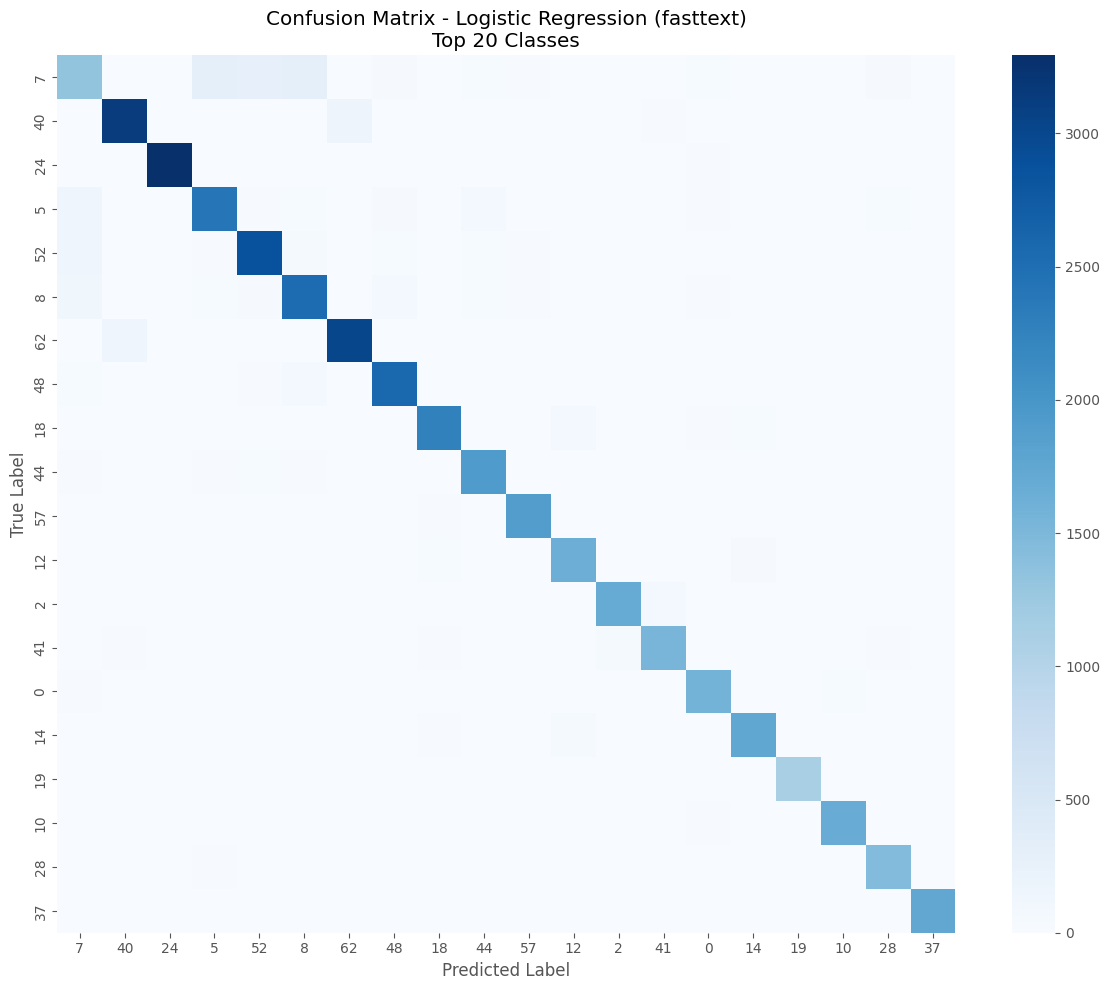

In [18]:
def text_to_fasttext_vector(text, ft_model):
    """Convert text to averaged FastText vector."""
    tokens = tokenize_text(text)
    vectors = [ft_model.wv[word] for word in tokens if word in ft_model.wv]
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(EMBEDDING_DIM)

print("Converting texts to FastText vectors...")
X_train_fasttext = np.array([text_to_fasttext_vector(text, fasttext_model) for text in X_train_text])
X_test_fasttext = np.array([text_to_fasttext_vector(text, fasttext_model) for text in X_test_text])

print(f"Train shape: {X_train_fasttext.shape}")
print(f"Test shape: {X_test_fasttext.shape}")

# Hyperparameter tuning
print("\nHyperparameter tuning for FastText...")
lr_fasttext_grid = GridSearchCV(
    LogisticRegression(random_state=RANDOM_SEED),
    param_grid_w2v,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
)

lr_fasttext_grid.fit(X_train_fasttext, y_train)

print(f"\nBest parameters: {lr_fasttext_grid.best_params_}")
print(f"Best CV F1-macro: {lr_fasttext_grid.best_score_:.4f}")

lr_fasttext = lr_fasttext_grid.best_estimator_

# Evaluate
y_pred_fasttext = lr_fasttext.predict(X_test_fasttext)

fasttext_accuracy = accuracy_score(y_test, y_pred_fasttext)
fasttext_macro_f1 = f1_score(y_test, y_pred_fasttext, average='macro')
fasttext_weighted_f1 = f1_score(y_test, y_pred_fasttext, average='weighted')

print("\n" + "="*70)
print("FastText Results:")
print("="*70)
print(f"Test Accuracy:    {fasttext_accuracy:.4f}")
print(f"Macro F1:         {fasttext_macro_f1:.4f}")
print(f"Weighted F1:      {fasttext_weighted_f1:.4f}")

# Save
save_classification_report(y_test, y_pred_fasttext, "fasttext")
save_model_and_embedder(lr_fasttext, fasttext_model, "fasttext")
plot_confusion_matrix(y_test, y_pred_fasttext, "fasttext")

## 10. Comparative Analysis

### 10.1 Summary Table

In [19]:
# Create comparison dataframe
results_comparison = pd.DataFrame({
    'Embedding': ['TF-IDF', 'Skip-gram', 'CBOW', 'FastText'],
    'Test Accuracy': [tfidf_accuracy, skipgram_accuracy, cbow_accuracy, fasttext_accuracy],
    'Macro F1': [tfidf_macro_f1, skipgram_macro_f1, cbow_macro_f1, fasttext_macro_f1],
    'Weighted F1': [tfidf_weighted_f1, skipgram_weighted_f1, cbow_weighted_f1, fasttext_weighted_f1],
})

print("\n" + "="*70)
print("MODEL COMPARISON - LOGISTIC REGRESSION")
print("="*70)
print(results_comparison.to_string(index=False))

# Save to CSV
comparison_path = os.path.join(OUTPUT_DIR, 'model_comparison_results.csv')
results_comparison.to_csv(comparison_path, index=False)
print(f"\nSaved comparison to: {comparison_path}")


MODEL COMPARISON - LOGISTIC REGRESSION
Embedding  Test Accuracy  Macro F1  Weighted F1
   TF-IDF        0.86650  0.835765     0.866234
Skip-gram        0.82114  0.765909     0.822031
     CBOW        0.80898  0.747160     0.810399
 FastText        0.79689  0.733585     0.798696

Saved comparison to: ../results\LogisticRegression\model_comparison_results.csv


### 10.2 Visualization - Performance Comparison

Saved comparison plot to: ../results\LogisticRegression\visual_graphs\model_comparison.png


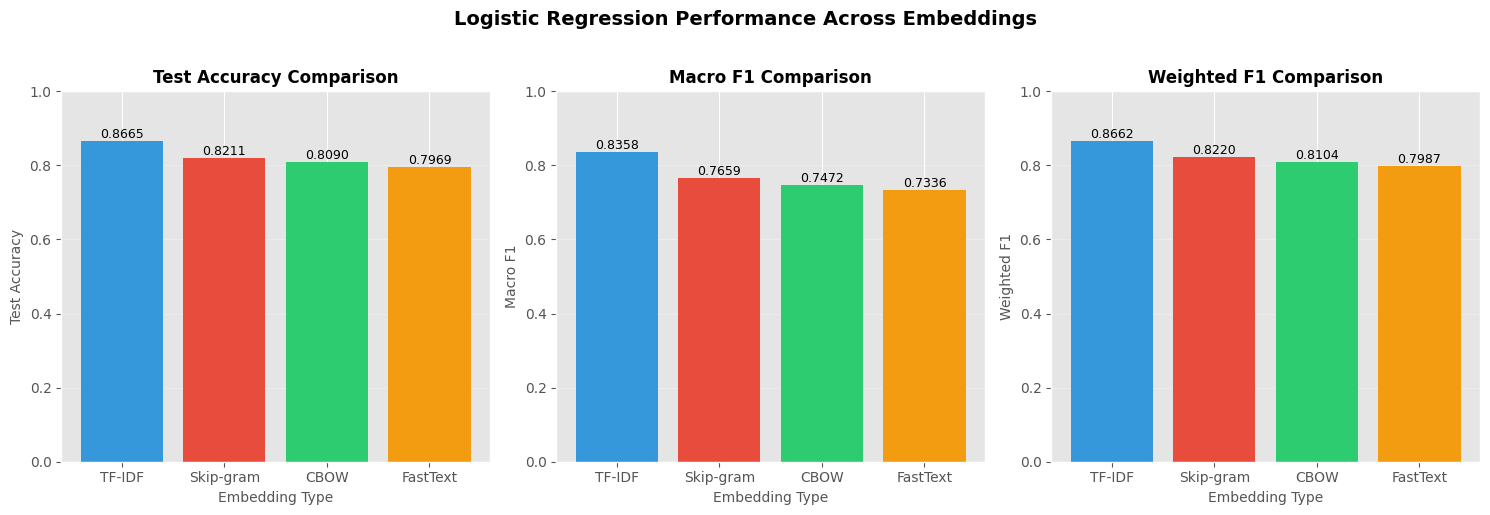

In [20]:
# Create comparison bar plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Test Accuracy', 'Macro F1', 'Weighted F1']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(results_comparison['Embedding'], results_comparison[metric], color=colors)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=10)
    ax.set_xlabel('Embedding Type', fontsize=10)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.suptitle('Logistic Regression Performance Across Embeddings', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

save_path = os.path.join(GRAPHS_DIR, 'model_comparison.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved comparison plot to: {save_path}")
plt.show()

### 10.3 Best Model Identification

In [21]:
# Find best performing embedding
best_accuracy_idx = results_comparison['Test Accuracy'].idxmax()
best_macro_f1_idx = results_comparison['Macro F1'].idxmax()
best_weighted_f1_idx = results_comparison['Weighted F1'].idxmax()

print("\n" + "="*70)
print("BEST PERFORMING EMBEDDINGS")
print("="*70)
print(f"Best Accuracy:    {results_comparison.loc[best_accuracy_idx, 'Embedding']} "
      f"({results_comparison.loc[best_accuracy_idx, 'Test Accuracy']:.4f})")
print(f"Best Macro F1:    {results_comparison.loc[best_macro_f1_idx, 'Embedding']} "
      f"({results_comparison.loc[best_macro_f1_idx, 'Macro F1']:.4f})")
print(f"Best Weighted F1: {results_comparison.loc[best_weighted_f1_idx, 'Embedding']} "
      f"({results_comparison.loc[best_weighted_f1_idx, 'Weighted F1']:.4f})")


BEST PERFORMING EMBEDDINGS
Best Accuracy:    TF-IDF (0.8665)
Best Macro F1:    TF-IDF (0.8358)
Best Weighted F1: TF-IDF (0.8662)


### 10.4 Per-Class Performance Analysis

In [22]:
# Get per-class F1 scores for all embeddings
def get_per_class_f1(y_true, y_pred):
    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    return f1

f1_tfidf = get_per_class_f1(y_test, y_pred_tfidf)
f1_skipgram = get_per_class_f1(y_test, y_pred_skipgram)
f1_cbow = get_per_class_f1(y_test, y_pred_cbow)
f1_fasttext = get_per_class_f1(y_test, y_pred_fasttext)

# Create dataframe
per_class_df = pd.DataFrame({
    'Class ID': range(len(f1_tfidf)),
    'TF-IDF F1': f1_tfidf,
    'Skip-gram F1': f1_skipgram,
    'CBOW F1': f1_cbow,
    'FastText F1': f1_fasttext,
})

print("\nPer-class F1 scores (first 10 classes):")
print(per_class_df.head(10).to_string(index=False))

# Find classes where embeddings differ most
per_class_df['Max Diff'] = per_class_df[['TF-IDF F1', 'Skip-gram F1', 'CBOW F1', 'FastText F1']].max(axis=1) - \
                            per_class_df[['TF-IDF F1', 'Skip-gram F1', 'CBOW F1', 'FastText F1']].min(axis=1)

print("\nClasses with largest performance differences:")
print(per_class_df.nlargest(10, 'Max Diff')[['Class ID', 'TF-IDF F1', 'Skip-gram F1', 'CBOW F1', 'FastText F1', 'Max Diff']].to_string(index=False))


Per-class F1 scores (first 10 classes):
 Class ID  TF-IDF F1  Skip-gram F1  CBOW F1  FastText F1
        0   0.912642      0.868254 0.850817     0.834521
        1   0.671299      0.651386 0.631010     0.610390
        2   0.951265      0.923407 0.905640     0.907183
        3   0.500000      0.067227 0.030612     0.035088
        4   0.839911      0.809374 0.789991     0.767123
        5   0.840989      0.766817 0.759602     0.746712
        6   0.873518      0.834139 0.832184     0.818934
        7   0.565826      0.497187 0.470166     0.455357
        8   0.859514      0.809023 0.790927     0.784527
        9   1.000000      0.375000 0.200000     0.153846

Classes with largest performance differences:
 Class ID  TF-IDF F1  Skip-gram F1  CBOW F1  FastText F1  Max Diff
        9   1.000000      0.375000 0.200000     0.153846  0.846154
        3   0.500000      0.067227 0.030612     0.035088  0.469388
       46   0.861423      0.530120 0.466809     0.451745  0.409678
       13   0.680

## 11. Key Insights and Conclusions

In [23]:
print("\n" + "="*70)
print("EXPERIMENT SUMMARY")
print("="*70)
print(f"""
Total Training Samples: {len(y_train):,}
Total Test Samples:     {len(y_test):,}
Number of Classes:      {len(np.unique(y_train))}

Embeddings Tested:
1. TF-IDF (10,000 features, unigrams + bigrams)
2. Word2Vec Skip-gram ({EMBEDDING_DIM}d, window={WINDOW_SIZE})
3. Word2Vec CBOW ({EMBEDDING_DIM}d, window={WINDOW_SIZE})
4. FastText ({EMBEDDING_DIM}d, window={WINDOW_SIZE})

Model: Logistic Regression
- Hyperparameter tuning: GridSearchCV (3-fold CV)
- Optimization metric: F1-macro
- Class weighting: Balanced

All results saved to: {OUTPUT_DIR}
""")

# Create final summary JSON
summary = {
    "experiment_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_type": "Logistic Regression",
    "dataset": {
        "train_samples": int(len(y_train)),
        "test_samples": int(len(y_test)),
        "num_classes": int(len(np.unique(y_train))),
    },
    "results": {
        "tfidf": {
            "accuracy": float(tfidf_accuracy),
            "macro_f1": float(tfidf_macro_f1),
            "weighted_f1": float(tfidf_weighted_f1),
        },
        "skipgram": {
            "accuracy": float(skipgram_accuracy),
            "macro_f1": float(skipgram_macro_f1),
            "weighted_f1": float(skipgram_weighted_f1),
        },
        "cbow": {
            "accuracy": float(cbow_accuracy),
            "macro_f1": float(cbow_macro_f1),
            "weighted_f1": float(cbow_weighted_f1),
        },
        "fasttext": {
            "accuracy": float(fasttext_accuracy),
            "macro_f1": float(fasttext_macro_f1),
            "weighted_f1": float(fasttext_weighted_f1),
        },
    },
    "best_embedding": {
        "by_accuracy": results_comparison.loc[best_accuracy_idx, 'Embedding'],
        "by_macro_f1": results_comparison.loc[best_macro_f1_idx, 'Embedding'],
        "by_weighted_f1": results_comparison.loc[best_weighted_f1_idx, 'Embedding'],
    }
}

summary_path = os.path.join(OUTPUT_DIR, 'experiment_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nSaved experiment summary to: {summary_path}")
print("\n✓ ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")


EXPERIMENT SUMMARY

Total Training Samples: 399,997
Total Test Samples:     100,000
Number of Classes:      63

Embeddings Tested:
1. TF-IDF (10,000 features, unigrams + bigrams)
2. Word2Vec Skip-gram (100d, window=5)
3. Word2Vec CBOW (100d, window=5)
4. FastText (100d, window=5)

Model: Logistic Regression
- Hyperparameter tuning: GridSearchCV (3-fold CV)
- Optimization metric: F1-macro
- Class weighting: Balanced

All results saved to: ../results\LogisticRegression


Saved experiment summary to: ../results\LogisticRegression\experiment_summary.json

✓ ALL EXPERIMENTS COMPLETED SUCCESSFULLY!
